In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from thefuzz import fuzz
from thefuzz import process

cars = pd.read_csv("./concatenated_data.csv", index_col=0)
del cars["description"]
cars.columns = [
    "brand",
    "model",
    "price",
    "mileage",
    "year",
    "location",
    "date_added",
    "body_type",
    "fuel",
    "power",
    "transmission",
    "color",
    "price_new",
    "engine_size",
]
cars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9437 entries, 0 to 5880
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         9411 non-null   object 
 1   model         9411 non-null   object 
 2   price         9432 non-null   float64
 3   mileage       9411 non-null   float64
 4   year          9411 non-null   object 
 5   location      9421 non-null   object 
 6   date_added    3336 non-null   object 
 7   body_type     9191 non-null   object 
 8   fuel          9411 non-null   object 
 9   power         9411 non-null   object 
 10  transmission  9411 non-null   object 
 11  color         9400 non-null   object 
 12  price_new     1955 non-null   float64
 13  engine_size   5855 non-null   object 
dtypes: float64(3), object(11)
memory usage: 1.1+ MB


# Overview


In [68]:
cars.describe()

,price,mileage,price_new
count,9.432000e+03,9.411000e+03,1955.000000
mean,3.309366e+07,2.361327e+12,171507.106905
std,1.645900e+09,1.619689e+14,136366.008481
min,-1.000000e+00,-2.200000e+05,29510.000000
25%,8.000000e+03,2.400000e+04,79990.000000
50%,3.300000e+04,1.010000e+05,136480.000000
75%,5.992500e+04,1.800000e+05,215000.000000
max,1.111111e+11,1.111111e+16,908000.000000


In [69]:
def summary_statistics(dataset):
    print(" summary statistics")
    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.nanmedian(dataset), 2)
    min_value = np.round(dataset.min(), 2)
    max_value = np.round(dataset.max(), 2)
    q1 = np.round(dataset.quantile(0.25), 2)
    q3 = np.round(dataset.quantile(0.75), 2)
    # Interquartile range
    iqr = np.round(q3 - q1, 2)
    print("Min: %s" % min_value)
    print("Mean: %s" % mean)
    print("Max: %s" % max_value)
    print("25th percentile: %s" % q1)
    print("Median: %s" % median)
    print("75th percentile: %s" % q3)
    print("Interquartile range (IQR): %s" % iqr)


# Strings


Applying str.title() to each column and specifying the field datatype


In [70]:
for col in cars.columns:
    if cars[col].dtype == "object":
        cars[col] = cars[col].str.title()


In [71]:
def explore_strings(df, column):
    # Specifying the field datatype
    df[column] = df[column].fillna("").astype(str)
    strings = df[column].unique()
    print(f"distinct {column}s : ", strings)
    print(f"number of distinct {column}s : ", len(strings) - 1)  # do not count ""
    return strings


## Location


Exploring the values of "location" column


In [72]:
locations = explore_strings(cars, "location")


In [73]:
def get_matches(df, column, string_to_match, min_ratio=50):
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = process.extract(
        string_to_match, strings, limit=10, scorer=fuzz.token_sort_ratio
    )
    # only get matches with a ratio >= min_ratio
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    return close_matches


In [74]:
def explore_matches(df, column, ratio=60):
    strings = df[column].unique()
    seen = set()
    for s in strings:
        if s in seen:
            continue
        if s == "":
            continue
        close_matches = get_matches(df, column, s, ratio)
        seen.update(close_matches)
        if len(close_matches) >= 2:
            print(f"close matches of {s}: {close_matches}")


In [75]:
explore_matches(cars, "location")


Unify and fix the values of the "location" column


In [76]:
my_dict = {"La Manouba": "Manouba", "Gabès": "Gabes"}
cars.replace({"location": my_dict}, inplace=True)


In [77]:
locations = explore_strings(cars, "location")


## Color


In [78]:
colors = explore_strings(cars, "color")


Brouillon


In [79]:
# get all the words that match "gris"
matches = process.extract("gris", colors, limit=20, scorer=fuzz.token_sort_ratio)
# take a look at them to choose min_ratio
matches


[('Gris', 100),
 ('Grise', 89),
 ('Gris Foncé', 62),
 ('Bleu Gris', 62),
 ('Bleu/Gris', 62),
 ('Gris Shark', 57),
 ('Mauve Gris', 57),
 ('Gris Argent', 53),
 ('Gris Métallisé', 50),
 ('Gris Charbon', 50),
 ('Gris Titanuim', 47),
 ('Gris Magnetic', 47),
 ('Grenadine', 46),
 ('Grise Métallisée', 44),
 ('Gris Anthracite', 42),
 ('Grise Metalisee', 42),
 ('Corail', 40),
 ('Gris Clair Métallisé', 36),
 ('Blanc Cristal', 35),
 ('Bleu Roi', 33)]

In [80]:
colors_gris = ["gris" if c.lower().startswith("gris") else c for c in colors]

colors_gris = [c[:-4] if c.lower().endswith("gris") else c for c in colors_gris]

matches = process.extract("Gris a", colors, limit=30, scorer=fuzz.token_sort_ratio)
score = fuzz.token_sort_ratio("gris ", "Gris Anthracite")
print(score)
matches

42


[('Gris', 80),
 ('Grise', 73),
 ('Gris Argent', 71),
 ('Gris Foncé', 67),
 ('Bleu Gris', 67),
 ('Bleu/Gris', 67),
 ('Gris Charbon', 67),
 ('Gris Anthracite', 57),
 ('Blanc Cristal', 53),
 ('Gris Shark', 50),
 ('Mauve Gris', 50),
 ('Gris Clair Métallisé', 50),
 ('Gris Métallisé', 44),
 ('Bleu Roi', 43),
 ('Gris Titanuim', 42),
 ('Gris Magnetic', 42),
 ('Aubergine', 40),
 ('Grise Métallisée', 40),
 ('Grenadine', 40),
 ('Grise Metalisee', 38),
 ('Autre', 36),
 ('Maran', 36),
 ('Orange', 33),
 ('Marron', 33),
 ('Bleu Métallisé', 33),
 ('Argent', 33),
 ('Corail', 33),
 ('Bleu Métallisée', 32),
 ('Rouge Bordeaux', 30),
 ('Titanium', 29)]

In [81]:
def replace_matches_in_column(df, column, string_to_match, min_ratio=47):
    # only get matches with a ratio > 90
    close_matches = get_matches(df, column, string_to_match, min_ratio)

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    # let us know the function's done
    print("All done!")


In [82]:
def replace_colors(df, column, color):
    shades = [c for c in column if c.lower().strip().startswith(color)]
    rows_with_matches = df["color"].isin(shades)
    df.loc[rows_with_matches, "color"] = color.title()


In [83]:
replace_colors(cars, colors, "gris")
replace_colors(cars, colors, "bleu")
replace_colors(cars, colors, "blanc")
replace_colors(cars, colors, "vert")
replace_colors(cars, colors, "rouge")
replace_colors(cars, colors, "noir")

Unify and fix the values of the "color" column


In [84]:
my_dict = {
    "Argent": "Gris",
    "Feuille D'Argent": "Gris",
    "Titanium": "Gris",
    "Miel": "Doré",
    "Champagne": "Jaune",
    "Grenadine": "Rouge",
    "Rouge Bordeaux": "Rouge",
    "Mauve Gris": "Mauve",
    "Aubergine": "Violet",
    "Maran": "Marron",
    "Corail": "Orange",
}
cars.replace({"color": my_dict}, inplace=True)

If color is "**\***" -> color = nan


In [85]:
specified_color = cars["color"] == "*****"
cars[specified_color] = np.nan


In [86]:
colors_clean = explore_strings(cars, "color")


## Model


In [87]:
models = explore_strings(cars, "model")


distinct models :  ['T Roc' 'Zs' 'Cerato 5P' 'Sportage' 'A4' 'Partner' 'Classe C' 'Gla' 'Q3'
 'Classe B' 'Golf 7' 'Classe C Coupe' 'Serie 3' 'Logan Mcv' 'A3'
 'Ecosport' 'Serie 4 Gran Coupe' '208' 'Ml' 'Clio' 'D Max' '3008' 'Polo'
 'A5 Sportback' 'H 1' 'Cla' 'Classe E Coupe' 'Mondeo' 'Cayenne' '206 Plus'
 'Rio 5P' 'Hs' '3' 'Serie 5' 'Tivoli' 'Compass' '206' 'Q7' '308' 'Leon'
 'Jetta' 'Formentor' 'Macan' 'Qashqai' 'Q2' 'Serie 7' 'Tiguan' 'Fusion'
 'H6' 'Golf 8' 'Focus' 'C3' 'A5 Coupe' 'Staria' 'Viano' 'Doblo' 'H2'
 'Rexton' 'Jolion' 'Discovery' '2008' 'Symbol' 'Passat Cc'
 'Discovery Sport' 'Tiggo 3' 'Classe S' 'E Pace' 'Range Rover Evoque'
 'Ds3' 'Classe A' 'Qx56' 'Polo Sedan' 'F Pace' 'Classe E' 'Seltos' 'Iris'
 'Patrol' 'Ateca' 'Gc 6' 'Picanto' 'Arona' 'Gs' 'Amarok' 'A3 Berline'
 'A3 Sportback' 'Sx3' 'City' 'S5' 'C Hr' 'Mustang' 'Tipo Berline' 'Golf 6'
 'Serie 2 Active Tourer' 'M4' 'Tipo' 'Transit' 'Megane Sedan'
 'Punto Classic' 'Glc Coupe' 'Serie 1 5P' 'Kuv 100' 'Renegade'
 'Partne

In [88]:
already = set()
k = 0
for m in models:
    if m == "":
        continue
    if m in already:
        continue

    close_matches = get_matches(cars, "model", m, 80)
    already.update(set(close_matches))
    if len(close_matches) >= 2:
        k += 1
        print(f"close matches of {m}: {close_matches}")


print(k)


close matches of Cerato 5P: ['Cerato 5P', 'Cerato']
close matches of A4: ['A4', 'Ax4']
close matches of Classe C: ['Classe C', 'Classe Cla', 'Classe B', 'Classe A']
close matches of Gla: ['Gla', 'Gl']
close matches of Golf 7: ['Golf 7', 'Golf 8', 'Golf 6', 'Golf 5', 'Golf 4', 'Golf 2', 'Golf 3', 'Golf']
close matches of Classe C Coupe: ['Classe C Coupe', 'Classe E Coupe']
close matches of Serie 3: ['Serie 3', 'Serie 5', 'Serie 7', 'Serie 4', 'Serie 1', 'Serie 2', 'Serie 3 Gt']
close matches of Serie 4 Gran Coupe: ['Serie 4 Gran Coupe', 'Serie 2 Gran Coupe', 'Serie 4 Coupe']
close matches of 208: ['208', '2008']
close matches of D Max: ['D Max', 'D-Max']
close matches of 3008: ['3008', '308', '300']
close matches of Polo: ['Polo', 'Polo 7', 'Polo 6', 'Polo 4', 'Polo 3']
close matches of A5 Sportback: ['A5 Sportback', 'A3 Sportback', 'A7 Sportback', 'A1 Sportback', 'Q5 Sportback', 'Q3 Sportback']
close matches of H 1: ['H 1', 'H-1']
close matches of Cla: ['Cla', 'Cl']
close matches of 20

Unify and fix the values of the "model" column


In [89]:
my_dict = {
    "D-Max": "D Max",
    "H-1": "H 1",
    "Over.Range Rover Sport": "Range Rover Sport",
    "Hr-V": "Hr V",
    "Bt-50": "Bt 50",
    "Hi.Lux": "Hilux",
    "Cx 5": "Cx 5",
    "C-Elysee": "C Elysée",
    "C Elysee": "C Elysée",
    "Cx-9": "Cx 9",
    "Autres": "Autre",
    "X-Trail": "X Trail",
    "Country Man": "Countryman",
    ".Country Man": "Countryman",
    "PickUp": "Pickup",
    "Cee'D": "Ceed",
    "C'Eed": "Ceed",
    "Serie 1": "Série 1",
    "Hi.Ace": "Hi Ace",
    "Gol": "Golf",
    "Volkswagen.Golf": "Golf",
    "Volkswagen.Polo": "Polo",
}
cars.replace({"model": my_dict}, inplace=True)

In [90]:
models_clean = explore_strings(cars, "model")


distinct models :  ['T Roc' 'Zs' 'Cerato 5P' 'Sportage' 'A4' 'Partner' 'Classe C' 'Gla' 'Q3'
 'Classe B' 'Golf 7' 'Classe C Coupe' 'Serie 3' 'Logan Mcv' 'A3'
 'Ecosport' 'Serie 4 Gran Coupe' '208' 'Ml' 'Clio' 'D Max' '3008' 'Polo'
 'A5 Sportback' 'H 1' 'Cla' 'Classe E Coupe' 'Mondeo' 'Cayenne' '206 Plus'
 'Rio 5P' 'Hs' '3' 'Serie 5' 'Tivoli' 'Compass' '206' 'Q7' '308' 'Leon'
 'Jetta' 'Formentor' 'Macan' 'Qashqai' 'Q2' 'Serie 7' 'Tiguan' 'Fusion'
 'H6' 'Golf 8' 'Focus' 'C3' 'A5 Coupe' 'Staria' 'Viano' 'Doblo' 'H2'
 'Rexton' 'Jolion' 'Discovery' '2008' 'Symbol' 'Passat Cc'
 'Discovery Sport' 'Tiggo 3' 'Classe S' 'E Pace' 'Range Rover Evoque'
 'Ds3' 'Classe A' 'Qx56' 'Polo Sedan' 'F Pace' 'Classe E' 'Seltos' 'Iris'
 'Patrol' 'Ateca' 'Gc 6' 'Picanto' 'Arona' 'Gs' 'Amarok' 'A3 Berline'
 'A3 Sportback' 'Sx3' 'City' 'S5' 'C Hr' 'Mustang' 'Tipo Berline' 'Golf 6'
 'Serie 2 Active Tourer' 'M4' 'Tipo' 'Transit' 'Megane Sedan'
 'Punto Classic' 'Glc Coupe' 'Serie 1 5P' 'Kuv 100' 'Renegade'
 'Partne

## Brand


In [91]:
brands = explore_strings(cars, "brand").sort()


In [92]:
explore_matches(cars, "brand", 70)


In [93]:
my_dict = {
    "Mercedes-Benz": "Mercedes Benz",
    "Mercedes": "Mercedes Benz",
    "Land-Rover": "Land Rover",
}
cars.replace({"brand": my_dict}, inplace=True)


In [94]:
brands = explore_strings(cars, "brand")


## Body Type


In [95]:
body_types = explore_strings(cars, "body_type")


## Fuel


In [96]:
fuels = explore_strings(cars, "fuel")


Unify and fix the values of the "fuel" column


In [97]:
my_dict = {
    "Hybride (Essence/Électrique)": "Hybride",
    "Hybride (Diesel/Électrique)": "Hybride",
}
cars.replace({"fuel": my_dict}, inplace=True)

In [98]:
fuel_clean = explore_strings(cars, "fuel")

## Transmission


In [99]:
transmissions = explore_strings(cars, "transmission")


Unify and fix the values of the "transmission" column


In [100]:
my_dict = {
    "Mécanique": "Manuelle",
}
cars.replace({"transmission": my_dict}, inplace=True)


In [101]:
transmission_clean = explore_strings(cars, "transmission")


Convert the column "engine_size" to float


In [102]:
contains_symbol = cars["engine_size"].str.contains("[><]") & cars["engine_size"].notna()
cars.loc[contains_symbol, "engine_size"] = cars.loc[
    contains_symbol, "engine_size"
].apply(lambda string: string[1:])
cars.loc[cars["engine_size"].notna(), "engine_size"] = cars.loc[
    cars["engine_size"].notna(), "engine_size"
].apply(lambda string: string[:-1])
cars["engine_size"] = cars["engine_size"].astype(np.float64)


'' to nan


In [103]:
cars = cars.replace("", np.nan)
# cars.info()

# print( cars["color"].unique())


# Dropping duplicates


In [104]:
cars.drop_duplicates(inplace=True)


# Dates


Turn "date_added" column to datetime


In [ ]:
contains_hyphen = cars["year"].str.contains("-") & cars["year"].notna()
cars.loc[contains_hyphen, "year"] = cars.loc[contains_hyphen, "year"].apply(
    lambda string: string.split("-")[1]
)
contains_point = cars["year"].str.contains("[.]") & cars["year"].notna()
cars.loc[contains_point, "year"] = cars.loc[contains_point, "year"].apply(
    lambda string: string.split(".")[-1]
)
cars["year"] = cars["year"].astype(np.float64)


If 10<= year <= 23 -> year += 2000, if 60 <= year -> year += 1900, else year = nan


In [ ]:
year_between_0_and_23 = (cars["year"] >= 10) & (cars["year"] <= 23)
cars.loc[year_between_0_and_23, "year"] += 2000
year_more_than_60 = (cars["year"] >= 60) & (cars["year"] <= 99)
cars.loc[year_more_than_60, "year"] += 1900
correct_year = (cars["year"] >= 1960) & (cars["year"] <= 2023)
cars.loc[~correct_year, "year"] = np.nan


Remove month from year in the "year" column and convert it to float


In [ ]:
cars["date_added"] = pd.to_datetime(cars["date_added"])


EDA

In [ ]:
# year_between_0_and_23 = (cars["year"] >= 10) & (cars["year"] <= 23)
# cars.loc[year_between_0_and_23, "year"] += 2000
years=cars["year"].sort_values().unique()
years

# Numerical Data


## Mileage


mileage -> abs(mileage)


In [ ]:
cars["mileage"] = abs(cars["mileage"])


If mileage < 10 -> mileage = nan


In [ ]:
mileage_less_than_10 = cars["mileage"] < 10
cars.loc[mileage_less_than_10, "mileage"] = np.nan


If mileage <= 1000 -> mileage \*= 1000


In [ ]:
mileage_less_than_1000 = cars["mileage"] <= 1000
cars.loc[mileage_less_than_1000, "mileage"] *= 1000


If mileage >= 1 000 000 -> mileage = nan


In [ ]:
mileage_over_1000000 = cars["mileage"] >= 1000000
cars.loc[mileage_over_1000000, "mileage"] = np.nan


In [ ]:
mileage_over_1000000 = cars["mileage"] <5000
cars.loc[mileage_over_1000000, ["model","price","mileage", "year"]].sort_values(by="mileage", ascending=False)

# conclusion : milegae < 4000 & year <= 2020 -> np.nan 

In [ ]:
mileage_under_4000 = cars["mileage"] <4000
old=cars["year"]< 2020
cars.loc[mileage_under_4000 & old, ["model","price","mileage", "year"]].sort_values(by="mileage", ascending=False)


In [ ]:
cars.loc[mileage_under_4000 & old, "mileage"]=np.nan


## Getting outliers


In [105]:
def get_outliers_z_score(df, column, threshold=4):
    mean = np.mean(df[column])
    std = np.std(df[column])
    return abs((df[column] - mean) / std) > threshold


In [106]:
def get_outliers_iqr(df, column):
    q1 = np.percentile(df.loc[df[column].notna(), column], 25)
    q3 = np.percentile(df.loc[df[column].notna(), column], 75)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (df[column] > upper_bound) | (df[column] < lower_bound)


## Power


Convert N.D to nan in the "power" column


In [107]:
power_is_ND = cars["power"] == "N.D"
cars.loc[power_is_ND, "power"] = np.nan


Convert the column "power" to float


In [108]:
contains_CV = cars["power"].str.contains("C") & cars["power"].notna()
cars.loc[contains_CV, "power"] = cars.loc[contains_CV, "power"].apply(
    lambda string: string.split()[0]
)
cars["power"] = cars["power"].astype(np.float64)


If power > 200 -> power = nan


In [109]:
power_over_200 = cars["power"] > 200
cars.loc[power_over_200, "power"] = np.nan

Get Mode Power per model and change the value of power if it exceeds the iqr range per model


In [110]:
model_to_power_mode = (
    cars.groupby("model")["power"]
    .apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan)
    .to_dict()
)
model_to_upper_bound = {}
for model in cars["model"].unique():
    try:
        df = cars.groupby("model").get_group(model)
    except KeyError:
        continue

    if df.empty:
        continue

    power_values = df.loc[df["power"].notna(), "power"]

    if power_values.empty:
        continue

    q1 = np.percentile(power_values, 25)
    q3 = np.percentile(power_values, 75)

    iqr = q3 - q1

    upper_bound = q3 + 1.5 * iqr
    model_to_upper_bound[model] = upper_bound

for model in cars["model"].unique():
    df = cars[cars["model"] == model]

    power_values = df.loc[df["power"].notna(), "power"]

    if power_values.empty:
        continue

    cars.loc[
        (cars["model"] == model) & (cars["power"] >= model_to_upper_bound[model]),
        "power",
    ] = model_to_power_mode[model]


## Price


 summary statistics
Min: -1.0
Mean: 22770380.76
Max: 111111111111.0
25th percentile: 20000.0
Median: 39000.0
75th percentile: 68950.0
Interquartile range (IQR): 48950.0


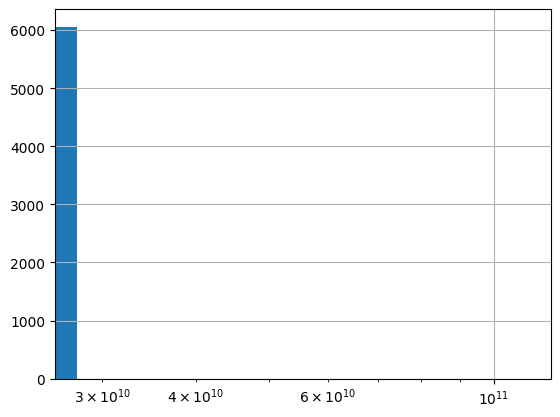

In [111]:
summary_statistics(cars["price"])
cars["price"].hist(bins=4)
plt.xscale("log")
plt.show()


price -> abs(price)
If price is 0 -> price = nan


In [112]:
cars["price"] = abs(cars["price"])
price_is_0 = cars["price"] <= 0
cars.loc[price_is_0, "price"] = np.nan


If price over 1_000_000 -> price = nan


In [113]:
price_over_1_000_000 = cars["price"] >= 1e6
cars.loc[price_over_1_000_000, "price"] = np.nan
price_under_500 = cars["price"] < 500
cars.loc[price_under_500, "price"] = np.nan


If price less than 500 -> price \*= 1000


              brand     model  year  mileage  price
244           Isuzu   Trooper  2000    200.0  999.0
243      Volkswagen    Golf 6  2023      1.0  850.0
1199  Mercedes Benz  Classe S     0      0.0  670.0


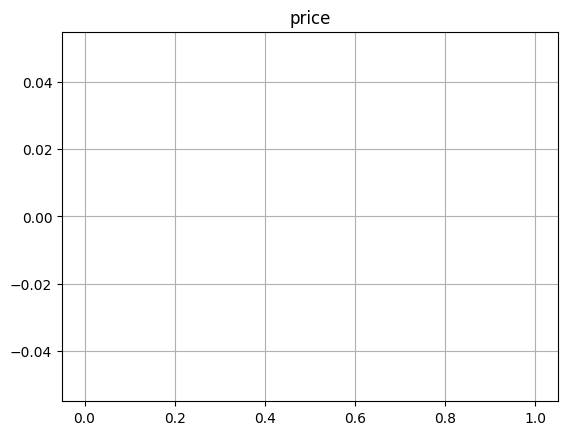

In [114]:
print(
    cars.loc[
        (cars["model"] =="206") & (cars["price"] < 100000),
        ["brand", "model", "year", "mileage", "price"],
    ].sort_values(by=["price", "year"], ascending=[False, True])
)
cars.loc[(cars["price"] > 1) & (cars["price"] < 500), ["price", "year"]].hist(bins=5)
plt.show()


In [115]:
price_less_than_1000 = cars["price"] <= 500
cars.loc[price_less_than_1000, "price"] *= 1000

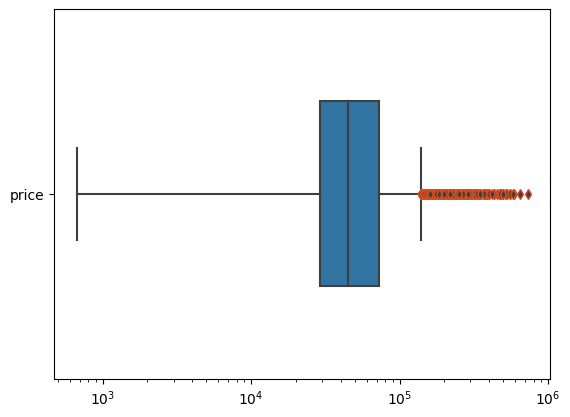

In [116]:
ax = sns.boxplot(
    data=cars[["price"]],
    width=0.5,
    orient="h",
    flierprops=dict(markeredgecolor="#D94D1F"),
)
plt.xscale("log")
plt.show()


price grouped by model


In [117]:
def calIQR(x):
    q3 = x.quantile(0.75)
    q1 = x.quantile(0.25)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (lower_bound, upper_bound)


cars_grouped = cars.groupby("model")
my_dict = cars_grouped["price"].apply(calIQR).to_dict()
# print(my_dict)


 summary statistics
Min: 670.0
Mean: 137833.57
Max: 280000.0
25th percentile: 93125.0
Median: 134250.0
75th percentile: 170500.0
Interquartile range (IQR): 77375.0


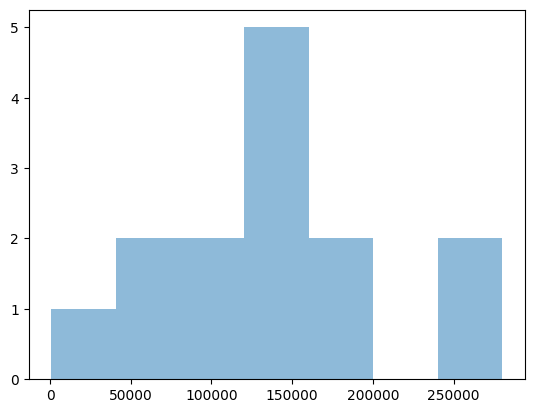

In [118]:
def histogram_by_model(grouped, model, column):
    grouped = cars.groupby("model")
    rows = grouped.get_group(model)
    summary_statistics(rows[column])

    plt.hist(rows[column], bins=7, alpha=0.5, label=model)


def boxplot_by_model(grouped, model, column):
    grouped = cars.groupby("model")

    rows = grouped.get_group(model)
    sns.boxplot(
        data=rows[[column]], orient="h", flierprops=dict(markeredgecolor="#D94D1F")
    )

    plt.show()


model = "Classe S"
histogram_by_model(cars_grouped, model, "price")
# boxplot_by_model(cars_grouped,model,"price")


-22937.5 286562.5
 summary statistics
Min: 670.0
Mean: 137833.57
Max: 280000.0
25th percentile: 93125.0
Median: 134250.0
75th percentile: 170500.0
Interquartile range (IQR): 77375.0


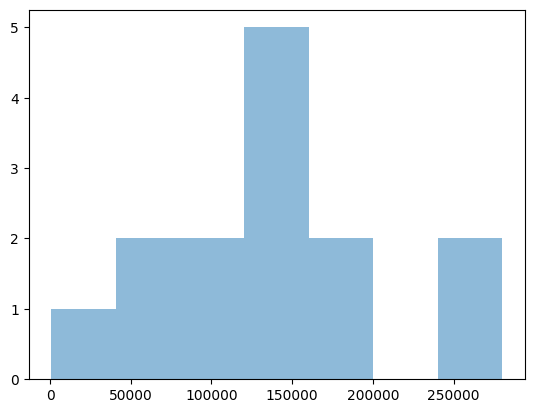

In [119]:
models = cars["model"].unique()
lower = my_dict[model][0]
upper = my_dict[model][1]

print(lower, upper)
filtered_cars = cars
cars.loc[
    (cars["model"] == model) & ((cars["price"] < lower) | (cars["price"] > upper)),
    "price",
] = np.nan

data=cars.loc[under_4000,
        ["brand", "model", "year", "mileage", "price"],
    ].sort_values(by=["year","price"], ascending=[False, True])
print(data)
plt.hist(data["year"], bins=7, alpha=0.5, label=model)

# for model in models:
#     if  model not in my_dict.keys()  :
#         print('hi')
#         continue

#     if str(my_dict[model][0]) == 'nan':
#         print("naaaaan")
#         continue
#     lower=my_dict[model][0]
#     upper=my_dict[model][1]

#     print(lower,upper)
#     cars.loc[(cars["model"] == model) & ((cars["price"] < lower) | (cars["price"] > upper )),
#             "price"
#         ] = np.nan

# boxplot_by_model(cars_grouped,"Rio","price")
histogram_by_model(cars_grouped, model, "price")


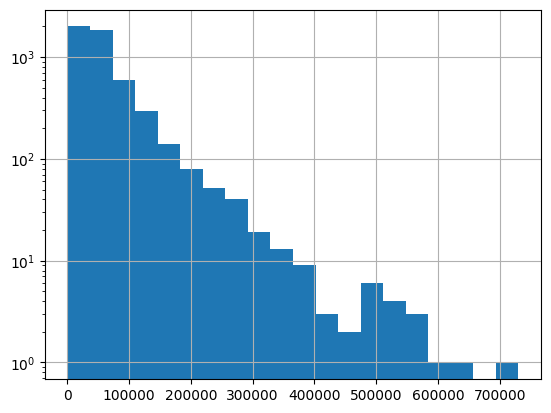

 summary statistics
Min: 670.0
Mean: 62633.25
Max: 730000.0
25th percentile: 28900.0
Median: 44900.0
75th percentile: 73000.0
Interquartile range (IQR): 44100.0


In [120]:
cars["price"].hist(bins=20)
plt.yscale("log")
plt.show()
summary_statistics(cars["price"])


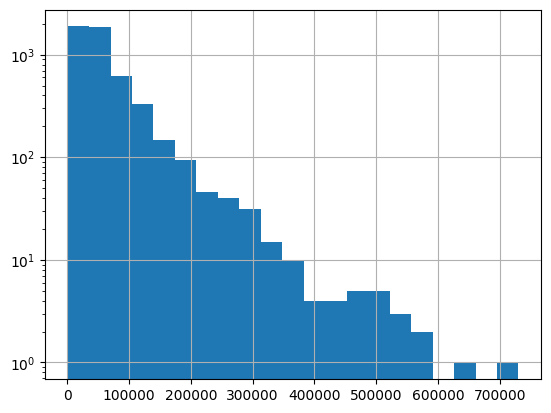

 summary statistics
Min: 670.0
Mean: 62633.25
Max: 730000.0
25th percentile: 28900.0
Median: 44900.0
75th percentile: 73000.0
Interquartile range (IQR): 44100.0


In [121]:
cars["price"].hist(bins=int((109_000.0 - 670.0) / 5_000))
plt.yscale("log")
plt.show()
summary_statistics(cars["price"])


In [122]:
cars.loc[cars["price"] > 400_000]


,brand,model,price,mileage,year,location,date_added,body_type,fuel,power,transmission,color,price_new,engine_size
122,Jaguar,F Pace,450000.0,28000.0,01-2018,Tunis,27.03.2023,4 X 4,Essence,24.0,Automatique,Blanc,390000.0,NaN
561,Porsche,Macan,465000.0,7500.0,05-2022,Sfax,26.03.2023,4 X 4,Essence,17.0,Automatique,Bleu,427500.0,NaN
575,Mercedes Benz,Gle Coupe,550000.0,50000.0,07-2021,Sfax,26.03.2023,4 X 4,Essence,12.0,Automatique,Blanc,540000.0,NaN
641,Porsche,Cayenne,480000.0,60000.0,01-2020,Ariana,25.03.2023,4 X 4,Essence,23.0,Automatique,Noir,570000.0,NaN
659,Bmw,X5,485000.0,34000.0,01-2020,Tunis,25.03.2023,4 X 4,Essence,23.0,Automatique,Blanc,NaN,NaN
755,Land Rover,Range Rover,650000.0,62000.0,03-2017,Tunis,23.03.2023,4 X 4,Essence,43.0,Automatique,Noir,908000.0,NaN
817,Land Rover,Range Rover,730000.0,40000.0,07-2018,Tunis,23.03.2023,4 X 4,Diesel,19.0,Automatique,Noir,908000.0,NaN
905,Porsche,Cayenne,430000.0,130000.0,07-2015,Tunis,23.03.2023,4 X 4,Essence,21.0,Automatique,Gris,570000.0,NaN
1072,Porsche,Cayenne,485000.0,69000.0,03-2019,Ariana,20.03.2023,4 X 4,Essence,23.0,Automatique,Blanc,570000.0,NaN
1090,Land Rover,Range Rover Sport,520000.0,35000.0,12-2020,Tunis,20.03.2023,4 X 4,Essence,28.0,Automatique,Blanc,695000.0,NaN


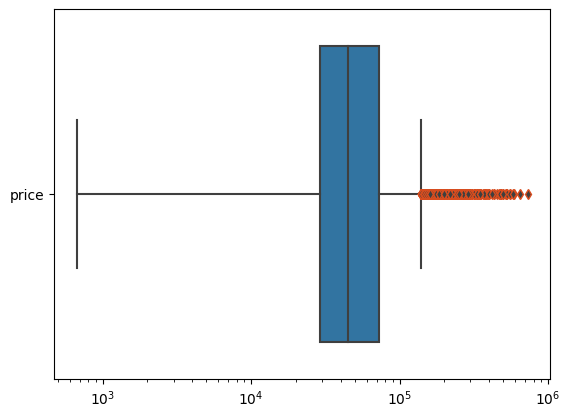

In [123]:
sns.boxplot(
    data=cars[["price"]], orient="h", flierprops=dict(markeredgecolor="#D94D1F")
)
plt.xscale("log")

plt.show()


recent=cars["year"]>2000
cars.loc[under_4000 & recent,
        ["price"],
    ]=np.nan

price grouped by model

In [124]:
def calIQR(x):
    q3=x.quantile(.75)
    q1=x.quantile(.25)
    iqr=q3-q1
    lower_bound=q1-1.5*iqr
    upper_bound=q3+1.5*iqr
    return (lower_bound,upper_bound)

def callZscore(x):
    mean = np.mean(x, axis=0)
    std = np.std(x,axis=0)
    return abs((x - mean) / std)
    # return zscore(x)

    




IQR

In [125]:
cars_grouped=cars.groupby("model")
bounds = cars_grouped["price"].apply(calIQR)
# print(my_dict)

In [126]:

def histogram_by_model(grouped,model,column):
    grouped=cars.groupby("model")
    rows=grouped.get_group(model)
    summary_statistics(rows[column])

    plt.hist(rows[column], bins=7, alpha=0.5, label=model)

def boxplot_by_model(grouped,model,column):
    grouped=cars.groupby("model")

    rows=grouped.get_group(model)
    sns.boxplot(
    data=rows[[column]], orient="h", flierprops=dict(markeredgecolor="#D94D1F")
)

    plt.show()



In [ ]:
model="206"
histogram_by_model(cars_grouped,model,"price")
# boxplot_by_model(cars_grouped,model,"price")

In [127]:

models=cars['model'].unique()
lower=bounds[model][0]
upper=bounds[model][1]

# print(lower,upper)

cars.loc[(cars["model"] == model) & ((cars["price"] < lower) | (cars["price"] > upper )),
            "price"
        ] = np.nan


sum=0
for model in models:
    if  model not in bounds.keys()  : 
        continue

    if str(bounds[model][0]) == 'nan':
        continue
    lower=bounds[model][0]
    upper=bounds[model][1]
   
    print(lower,upper)
    out=cars.loc[(cars["model"] == model) & ((cars["price"] < lower) | (cars["price"] > upper )),
            "price"
        ] 
    sum+=out.shape[0]
    out=np.nan
    
        
print(sum)
# boxplot_by_model(cars_grouped,"Rio","price")
# histogram_by_model(cars_grouped,model,"price")



In [ ]:

data=cars.loc[(cars["price"] <4000) ,
        ["brand", "model", "year", "mileage", "price"],
    ].sort_values(by=["price", "year"], ascending=[False, True])
print(data
    
)


## z_score


In [128]:
models=cars["model"].unique()
threshold=2
for model in models:
    if str(model) =='nan' : 
        continue 
    df=cars_grouped.get_group(model)
    df["z_score"]=callZscore(df["price"])
    above_threshold=df["z_score"]> threshold
    outliers=df.loc[above_threshold,["z_score","price","year","mileage","price_new"]]
    indices=outliers.index.tolist()
    cars.loc[indices,"price" ]= np.nan

    




In [ ]:
cars["price"].hist(bins=20)
plt.yscale("log")
plt.show()
summary_statistics(cars["price"])


In [129]:
category1=cars.loc[cars["price"]<100_000,"price"]
category2=cars.loc[cars["price"]>=100_000,"price"]
category1.hist(bins=10)
plt.yscale("log")
plt.show()
summary_statistics(category1)


In [ ]:
cars.loc[cars["price"] > 400_000,["brand", "model", "year", "price"]]


In [130]:
sns.boxplot(
    data=cars[["price"]], orient="h", flierprops=dict(markeredgecolor="#D94D1F")
)
plt.xscale("log")

plt.show()


/tmp/ipykernel_2216/3095061778.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cars["date_added"] = pd.to_datetime(cars["date_added"])


In [131]:
cars.to_csv("./new_clean_data.csv")
cars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6060 entries, 0 to 5880
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   brand         6052 non-null   object        
 1   model         6052 non-null   object        
 2   price         5101 non-null   float64       
 3   mileage       5807 non-null   float64       
 4   year          5995 non-null   float64       
 5   location      6048 non-null   object        
 6   date_added    3317 non-null   datetime64[ns]
 7   body_type     5834 non-null   object        
 8   fuel          6052 non-null   object        
 9   power         6004 non-null   float64       
 10  transmission  6052 non-null   object        
 11  color         6041 non-null   object        
 12  price_new     1939 non-null   float64       
 13  engine_size   2517 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(7)
memory usage: 710.2+ KB
